# 百度网盘AI大赛-图像处理挑战赛：文档检测优化赛

基于[Baseline](https://aistudio.baidu.com/aistudio/projectdetail/3861946)，我们替换backbone，使用预训练好的模型Res2Net101_vd_26w_4s来回归图像中文档的拐角坐标完成百度网盘AI大赛-图像处理挑战赛：文档检测优化赛。

[比赛链接](https://aistudio.baidu.com/aistudio/competition/detail/207/0/introduction)

## 比赛介绍

生活中人们使用手机进行文档扫描逐渐成为一件普遍的事情，为了提高人们的使用体验，我们期望通过算法技术去除杂乱的拍摄背景并精准框取文档边缘，选手需要通过深度学习技术训练模型，对给定的真实场景下采集得到的带有拍摄背景的文件图片进行边缘智能识别，并最终输出处理后的扫描结果图片。

### 评测方式说明

1. 参赛选手提交的代码和模型只预测文档边缘的heatmap图，由后台评测脚本中预置的算法回归出文档区域的四个角的坐标点，并生成规则的四边形，与GT计算IoU值；
2. 参赛选手提交的代码和模型直接回归文档区域的四个角的坐标点，并生成规则的四边形，与GT计算IoU值。 注：两种评测方式的结果会放在一个排行榜内，评测脚本中预置的角点回归算法会存在一定的局限性，如果各位参赛选手希望获得更高的分数，建议采用第二种评测方式。

## 任务分析

本次比赛要求选手设计算法在给定图片中划定一块**四边形区域**，以尽可能与图片中的文档部分重合。

因此，本次任务可以同时看作**回归问题**和**分割问题**。

- 作为回归问题，需要设计学习器/其他方法寻找四边形的四个拐角坐标
- 作为分割问题，直接将数据中的segments作为标签训练对应的分割学习器即可

本项目将本次任务看作回归问题来处理，使用Res2Net101_vd_26w_4s+注意力双分支Linear层的网络结构回归四个角的坐标。

# 代码部分

## 获取数据




In [ ]:
! wget https://staticsns.cdn.bcebos.com/amis/2022-4/1649731549425/train_datasets_document_detection_0411.zip
! unzip -oq /home/aistudio/train_datasets_document_detection_0411.zip
! rm -rf __MACOSX
! rm -rf /home/aistudio/train_datasets_document_detection_0411.zip

## 构造数据读取器

通过paddle.io.dataset构造读取器，便于读取数据。

数据预处理包括：
1. 根据data_info的边缘轮廓信息分别提取四个拐角的位置。
2. 对图片进行resize和数据增强（调整明暗对比度等参数）

### 查看数据

In [1]:
def get_corner(positions, corner_flag, w, h):
    # corner_flag 1:top_left 2:top_right 3:bottom_right 4:bottom_left
        if corner_flag == 1:
            target_pos = [0,0]
        elif corner_flag == 2 :
            target_pos = [w,0]
        elif corner_flag == 3 :
            target_pos = [w,h]
        elif corner_flag == 4 :
            target_pos = [0,h]

        min_dis = h**2+w**2
        best_x = 0
        best_y = 0
        for pos in positions:
            now_dis = (pos[0]-target_pos[0])**2+(pos[1]-target_pos[1])**2
            if now_dis<min_dis:
                min_dis = now_dis
                corner_x = pos[0]
                corner_y = pos[1]
        
        return corner_x, corner_y

In [2]:
import os, cv2
import numpy as np

train_imgs_dir = '/home/aistudio/train_datasets_document_detection_0411/images/'
train_txt = '/home/aistudio/train_datasets_document_detection_0411/data_info.txt'
data_info = []
with open(train_txt,'r') as f:
    for line in f:
        line = line.strip().split(',')
        image_name = line[0]
        img = cv2.imread(os.path.join(train_imgs_dir, image_name+'.jpg'))
        h, w, c = img.shape

        positions = []
        for i in range(1,len(line),2):
            positions.append([float(line[i]), float(line[i+1])])
        label = []
        for i in range(4):
            corner_x, corner_y = get_corner(positions, i+1, w, h)
            label.append(corner_x)
            label.append(corner_y)

        data_info.append((image_name+'.jpg', label, (w, h)))

        break

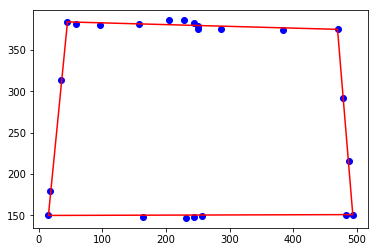

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
positions = np.array(positions)
label = np.array(label)
plt.plot(positions[:, 0], h-positions[:, 1], "ob")
plt.plot(label[[0, 2, 4, 6, 0]], h-label[[1, 3, 5, 7, 1]], "r")

我们将数据处理与构造的所有代码存放在work/dataset.py中，实验发现Baseline的数据增强操作的确能够带来少量性能提升

## 定义网络结构

我们认为强大的backbone有助于性能的提升，在保证满足要求的推理时间下，我们选择了预训练的resnet18、resnet50、resnet152、Res2Net101_vd_26w_4s作为backbone来选取较优的模型，在A榜的成绩证实了在Imagenet上效果更好的Res2Net101_vd_26w_4s在本次任务上性能更优。我们实验发现单分支的Linear层预测的角点坐标，不如以注意力值为权重双分支求和的双分支Linear层的预测效果好，有种按样本自适应集成的效果。
```
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet,self).__init__()
        self.backbone = Res2Net_vd(layers=101, scales=4, width=26)
        state_dict = paddle.load("Res2Net101_vd_26w_4s_ssld_pretrained.pdparams")
        self.backbone.set_state_dict(state_dict)
        self.fc1 = paddle.nn.Linear(self.backbone.pool2d_avg_channels, 8)
        self.fc2 = paddle.nn.Linear(self.backbone.pool2d_avg_channels, 8)

        self.attn = paddle.nn.Sequential(
            paddle.nn.ReLU(),
            paddle.nn.Linear(8, 32),
            paddle.nn.ReLU(),
            paddle.nn.Linear(32, 8),
            paddle.nn.Sigmoid()
            )


    def forward(self, img):
        y = self.backbone(img)
        y1 = self.fc1(y)
        y2 = self.fc2(y)

        coef = self.attn(y1+y2)
        y = y1*coef+y2*(1.-coef)

        return y
```

完整代码见work/model.py

## 训练
与Baseline不同，我们定义了模型性能度量标准miou，实验发现L1Loss要优于L2Loss，使用了更多的epochs，选用了相对更大的初始学习率，并对优化器和学习率衰减函数进行探索，最终使用Adam优化器及余弦衰减。

```
def cal_miou(bs, h, w, pred, label, mode='mean'):
    miou = 0
    for i in range(bs):
        mask_pre = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask_pre, 'L')
        corner_xy = [(pred[i, j]*w, pred[i, j+1]*h) for j in range(0, 8, 2)]
        draw.polygon(corner_xy, fill=1)
        mask_pre = np.array(mask_pre, dtype=np.float32)

        mask_gt = Image.new('L', (w, h), 0)
        draw = ImageDraw.Draw(mask_gt, 'L')
        corner_xy = [(label[i, j]*w, label[i, j+1]*h) for j in range(0, 8, 2)]
        draw.polygon(corner_xy, fill=1)
        mask_gt = np.array(mask_gt, dtype=np.float32)

        mul = (mask_gt*mask_pre).sum()
        iou = mul/(mask_gt.sum()+mask_pre.sum()-mul)
        miou = miou+iou

    if mode=="mean":
        return miou/bs
    elif mode=="sum":
        return miou
```
```
criterion = paddle.nn.L1Loss()#MSELoss()
```

In [ ]:
#划分训练集、验证集训练
%cd work/
!python main.py --save_dir output/train_val --epochs 100 --learning_rate 3.0e-4 --use_schedule True --train_ratio 0.8
%cd ../

In [ ]:
#全料数据训练
%cd work/
!python main.py --save_dir output/all_data --epochs 100 --learning_rate 3.0e-4 --use_schedule True
%cd ../

## 打包提交

本题目提交需要提交对应的模型和预测文件。predict.py需要读取同目录下的模型信息，并预测坐标点-保存为json或预测分割后的图片-保存为图片形式。

想要自定义训练模型，只需要将predict.py中的模型和process函数中的do something 替换为自己的模型内容即可。

**提交分割模型时，取消predict中52行的注释部分即可保存分割后的图片信息**

**注意model.eval()不要漏掉，不然分数会下降10个点左右**

In [6]:
# 压缩可提交文件
! zip submit_detection.zip model_best.pdparams predict.py

  adding: model.pdparams (deflated 7%)
  adding: predict.py (deflated 54%)


# 总结
本项目使用极简的方式完成了百度网盘AI大赛-图像处理挑战赛：文档检测优化赛，但仍有改进的空间。比如：
1. 本项目使用了Res2Net101_vd_26w_4s网络，可以尝试其他backbone。
2. 本项目使用的loss为L1loss，可以探索其他loss。
